# Analysis of workshop follow-up survey results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

### Load dataset

In [2]:
df = pd.read_csv("workshop-followup-survey-report_2.csv")
# replace space by underscore, DONT NEED TO
#df.columns = [c.replace(' ', '_') for c in df.columns]

# remove the GitHub-Pages question since it's probably misunderstood
#del df["GitHub/GitLab/BitBucket_Pages"]
del df["GitHub/GitLab/BitBucket Pages"]
df.head()

,Which workshop did you attend?,What is your current position?,Other,Version control,Automated testing,Travis CI,Code coverage analysis,Jupyter Notebooks,CMake,Integrated development environments,Code review,Read the docs,Reusable,Reproducible,Modular,Documented,Has it become easier for you to collaborate on software development with your colleagues and collaborators?,Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?
0,"Espoo, Finland, December 2016",Graduate student,NaN,I'm using this tool better than before,I started using this tool,I don't use this tool,I don't use this tool,I started using this tool,I started using this tool,I don't use this tool,I started using this tool,I'm using this tool better than before,1.0,1.0,1.0,1.0,1.0,1.0
1,"Stockholm, Sweden, February 2017",NaN,Staff Scientist,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,1.0,1.0,0.0,1.0,NaN,1.0
2,"Stockholm, Sweden, February 2017",Postdoc,NaN,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,I don't use this tool,I started using this tool,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I'm using this tool in the same way as before,1.0,1.0,0.0,0.0,0.0,1.0
3,"Stockholm, Sweden, February 2017",Postdoc,NaN,I'm using this tool in the same way as before,I'm using this tool better than before,I'm using this tool better than before,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I'm using this tool in the same way as before,I'm using this tool in the same way as before,I'm using this tool in the same way as before,1.0,1.0,1.0,1.0,1.0,1.0
4,"Espoo, Finland, December 2016",Researcher,NaN,I'm using this tool better than before,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,1.0,1.0,0.0,1.0,1.0,1.0


#### Add index column

In [3]:
df = df.reset_index()
df.head()

,index,Which workshop did you attend?,What is your current position?,Other,Version control,Automated testing,Travis CI,Code coverage analysis,Jupyter Notebooks,CMake,Integrated development environments,Code review,Read the docs,Reusable,Reproducible,Modular,Documented,Has it become easier for you to collaborate on software development with your colleagues and collaborators?,Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?
0,0,"Espoo, Finland, December 2016",Graduate student,NaN,I'm using this tool better than before,I started using this tool,I don't use this tool,I don't use this tool,I started using this tool,I started using this tool,I don't use this tool,I started using this tool,I'm using this tool better than before,1.0,1.0,1.0,1.0,1.0,1.0
1,1,"Stockholm, Sweden, February 2017",NaN,Staff Scientist,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,1.0,1.0,0.0,1.0,NaN,1.0
2,2,"Stockholm, Sweden, February 2017",Postdoc,NaN,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,I don't use this tool,I started using this tool,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I'm using this tool in the same way as before,1.0,1.0,0.0,0.0,0.0,1.0
3,3,"Stockholm, Sweden, February 2017",Postdoc,NaN,I'm using this tool in the same way as before,I'm using this tool better than before,I'm using this tool better than before,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I'm using this tool in the same way as before,I'm using this tool in the same way as before,I'm using this tool in the same way as before,1.0,1.0,1.0,1.0,1.0,1.0
4,4,"Espoo, Finland, December 2016",Researcher,NaN,I'm using this tool better than before,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,1.0,1.0,0.0,1.0,1.0,1.0


### How has your software development changed after attending a workshop?
Has your code become more 
1. Reusable?
2. Reproducible?
3. Modular?
4. Documented?

In [4]:
df[["Reusable","Reproducible", "Modular", "Documented"]].mean()

Reusable        0.846154
Reproducible    0.833333
Modular         0.600000
Documented      0.640000
dtype: float64

### How has working with colleagues changed after attending a workshop?
1. Has it become easier for you to collaborate on software development with your colleagues and collaborators?
2. Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop? 

In [5]:
col1 = [col for col in df.columns if 'Has it' in col]
col2 = [col for col in df.columns if 'Have you' in col]

df[[col1[0],col2[0]]].mean()

Has it become easier for you to collaborate on software development with your colleagues and collaborators?    0.777778
Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?      0.615385
dtype: float64

### Tools taught in workshops

In [6]:
first_index = df.columns.get_loc("Version control")
last_index = df.columns.get_loc("Read the docs")
tmp = df.columns[first_index:last_index+1].tolist()
lessons = [x.encode('utf-8') for x in tmp]
lessons

['Version control',
 'Automated testing',
 'Travis CI',
 'Code coverage analysis',
 'Jupyter Notebooks',
 'CMake',
 'Integrated development environments',
 'Code review',
 'Read the docs']

In [7]:
df2 = df[lessons]
df2.head()

,Version control,Automated testing,Travis CI,Code coverage analysis,Jupyter Notebooks,CMake,Integrated development environments,Code review,Read the docs
0,I'm using this tool better than before,I started using this tool,I don't use this tool,I don't use this tool,I started using this tool,I started using this tool,I don't use this tool,I started using this tool,I'm using this tool better than before
1,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool
2,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,I don't use this tool,I started using this tool,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I'm using this tool in the same way as before
3,I'm using this tool in the same way as before,I'm using this tool better than before,I'm using this tool better than before,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I'm using this tool in the same way as before,I'm using this tool in the same way as before,I'm using this tool in the same way as before
4,I'm using this tool better than before,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool


#### reshape dataframe

In [8]:
answers = pd.melt(df2,id_vars="index",value_vars=lessons,value_name="answer",var_name="lesson")
answers["index"]=1
answers=answers.rename(columns = {'index':'number'})
answers.head()

,number,lesson,answer
0,1,Version control,I'm using this tool better than before
1,1,Version control,I don't use this tool
2,1,Version control,I'm using this tool in the same way as before
3,1,Version control,I'm using this tool in the same way as before
4,1,Version control,I'm using this tool better than before


In [9]:
table = answers.pivot_table(values="number",index="answer", columns="lesson",aggfunc=np.sum)
table

lesson,Automated testing,CMake,Code coverage analysis,Code review,Integrated development environments,Jupyter Notebooks,Read the docs,Travis CI,Version control
answer,,,,,,,,,
I'm using this tool in the same way as before,3.0,5.0,5.0,1.0,7.0,3.0,4.0,1.0,4.0
I don't use this tool,14.0,13.0,16.0,16.0,10.0,10.0,14.0,23.0,3.0
I started using this tool,8.0,5.0,5.0,6.0,3.0,8.0,6.0,1.0,2.0
I'm using this tool better than before,1.0,3.0,NaN,3.0,6.0,5.0,2.0,1.0,17.0


### Have workshop attendants started using new tools, or started using them better?

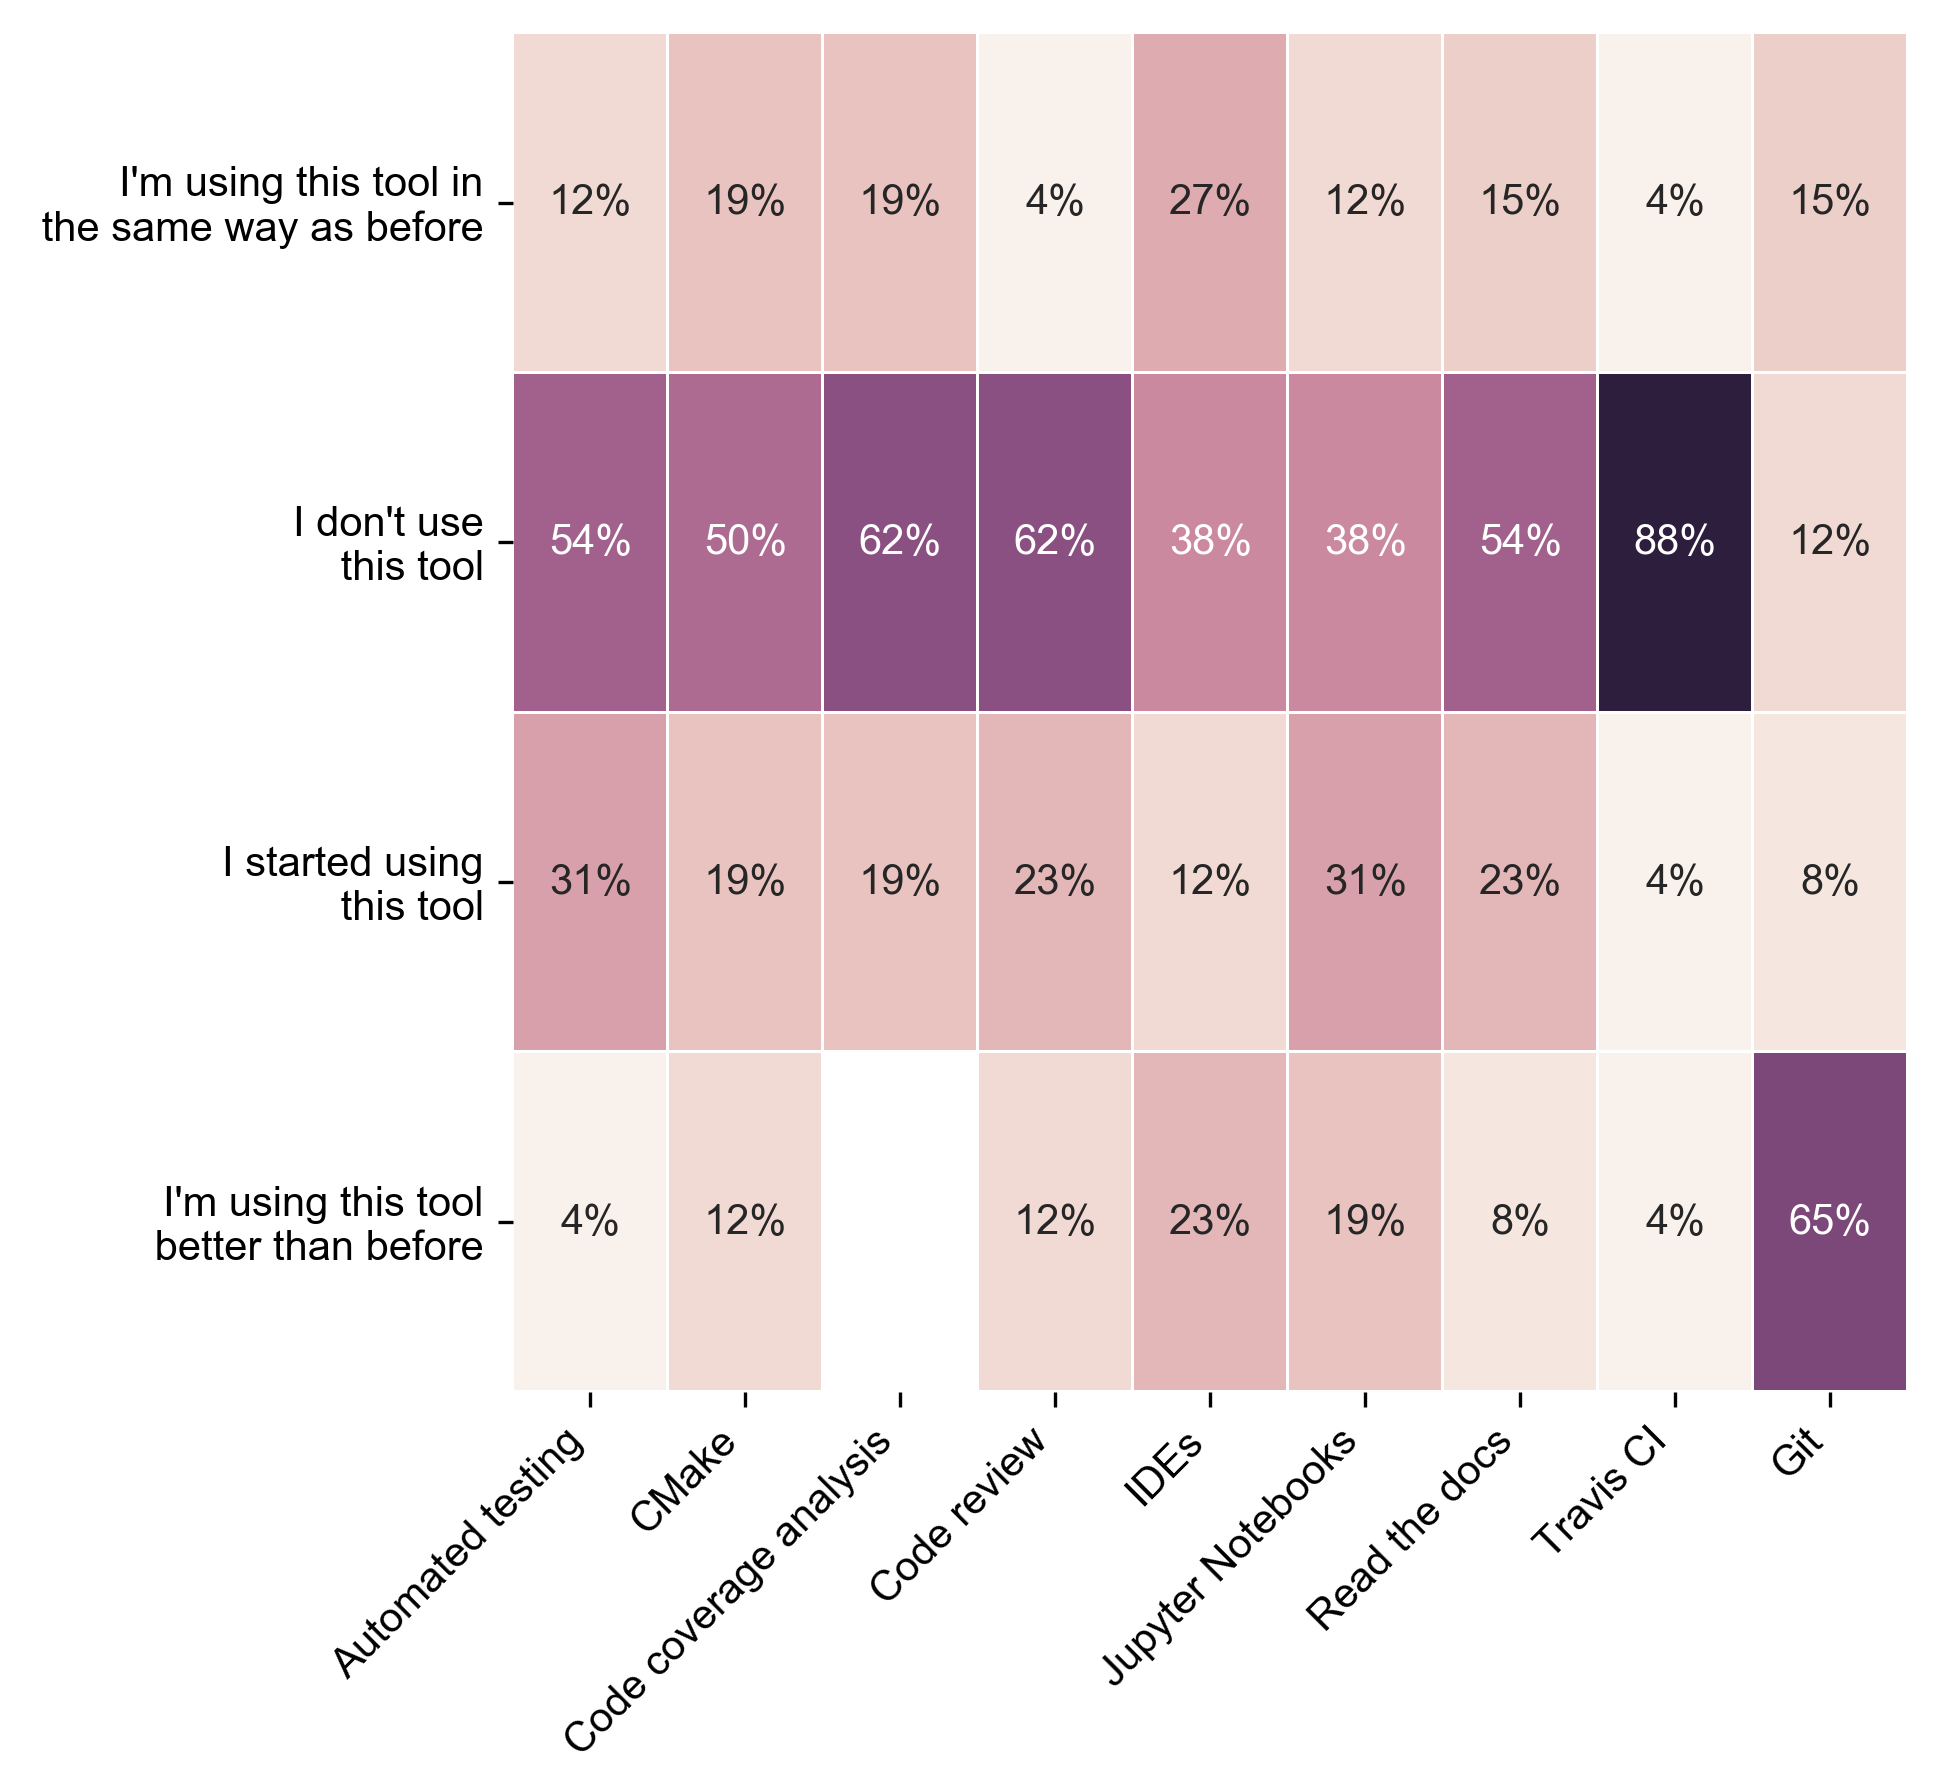

In [10]:
sns.reset_defaults()
sns.reset_orig()
fig, ax = plt.subplots(1, 1, figsize = (6,6), dpi=300)
# normalize
table_norm=(table)/table.sum()
# table for annotating cells 
annot = 100*table_norm.round(2)

# rename a bit for appearance
table_norm=table_norm.rename(columns = {'Version control':'Git'})
table_norm=table_norm.rename(columns = {'Integrated development environments':'IDEs'})
table_norm=table_norm.rename_axis({'I don\'t use this tool':'I don\'t use\n this tool'})
table_norm=table_norm.rename_axis({" I'm using this tool in the same way as before":
                                   "I\'m using this tool in\n the same way as before"})
table_norm=table_norm.rename_axis({"I\'m using this tool better than before":
                                   "I\'m using this tool\n better than before"})
table_norm=table_norm.rename_axis({"I started using this tool":"I started using\n this tool"})

g = sns.heatmap(table_norm,linewidths=.5, annot=annot,cbar=False);

# appearance
sns.set(font_scale=3)
for t in g.texts: t.set_text(t.get_text() + "%")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()
#plt.savefig("tmp.pdf")

#### Individual histograms

/Users/ktw/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


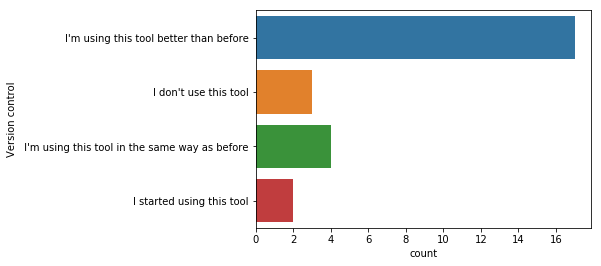

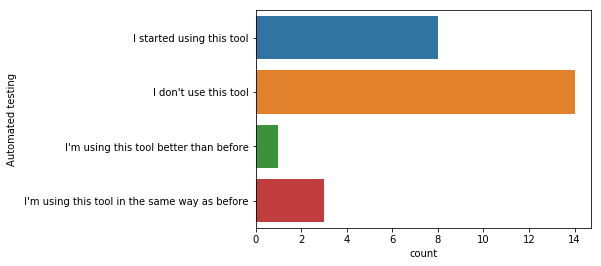

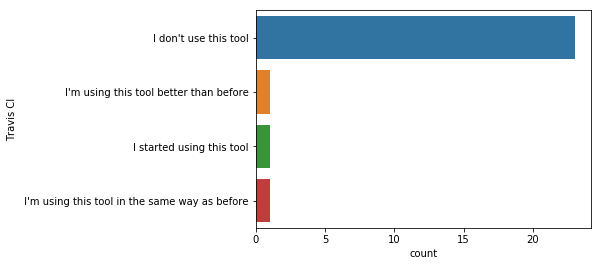

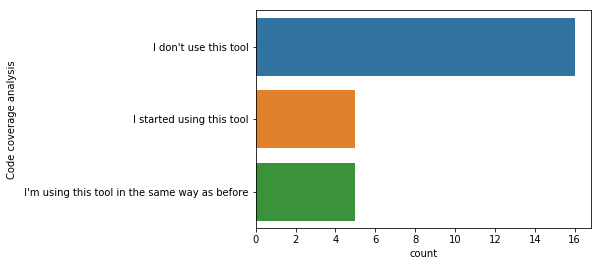

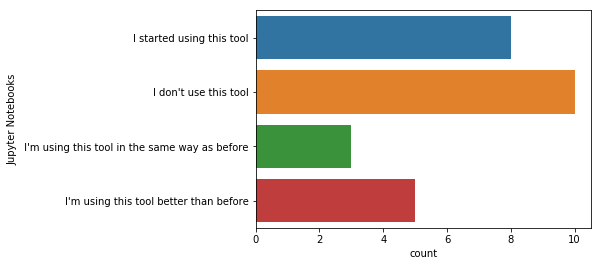

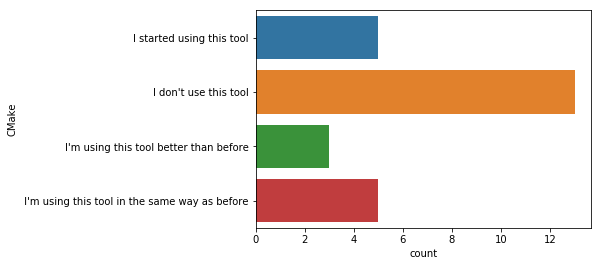

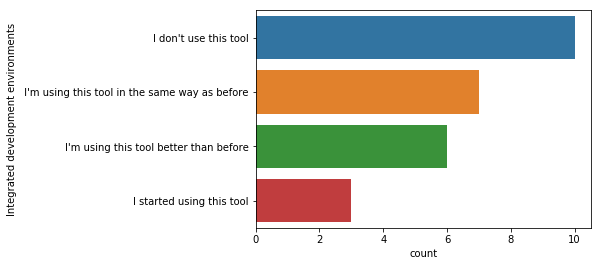

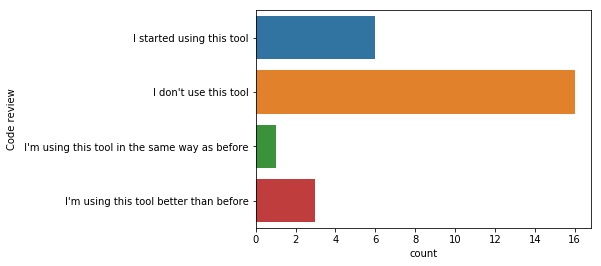

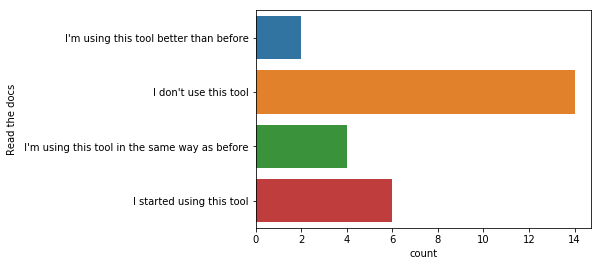

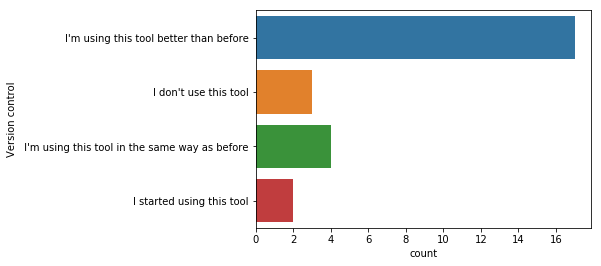

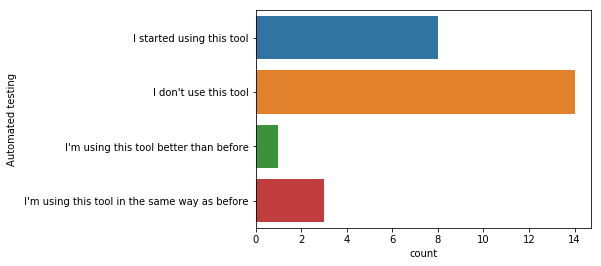

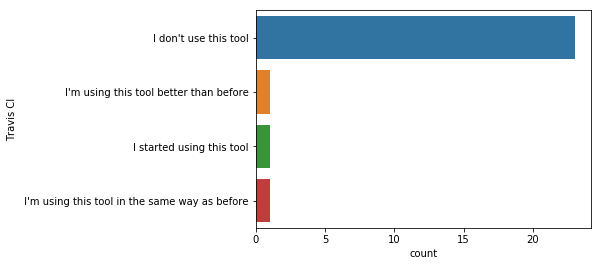

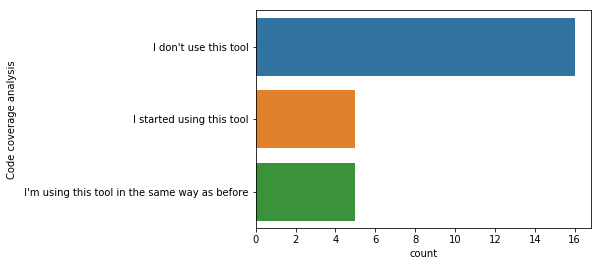

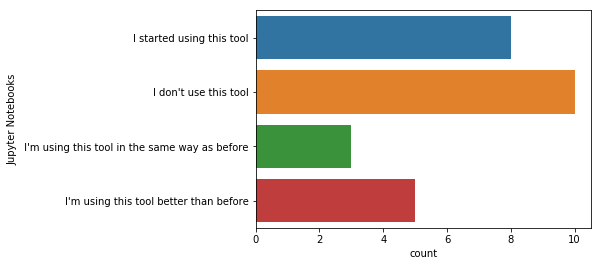

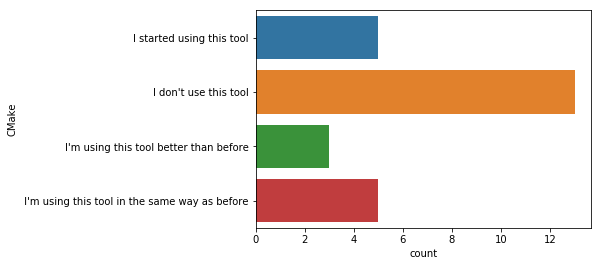

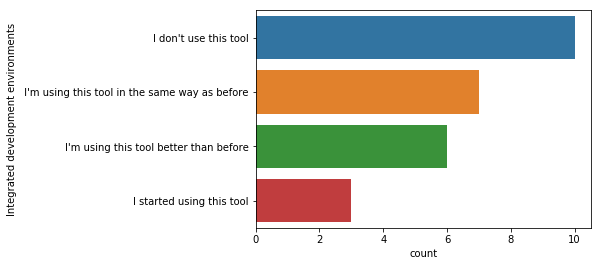

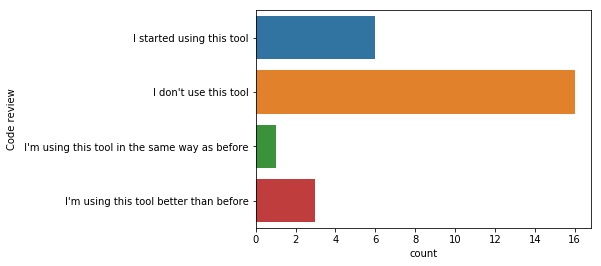

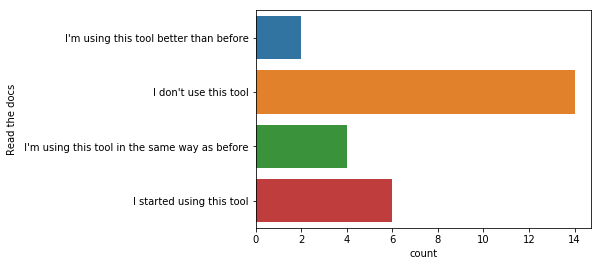

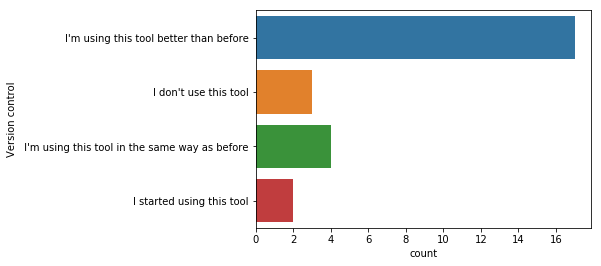

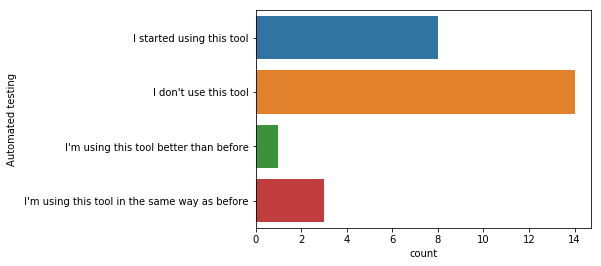

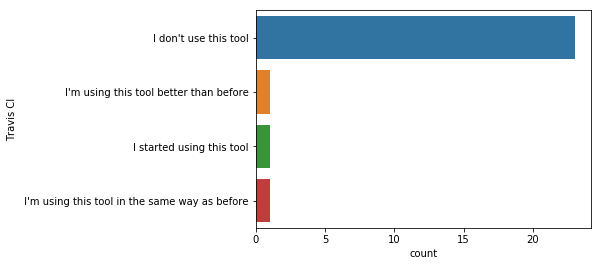

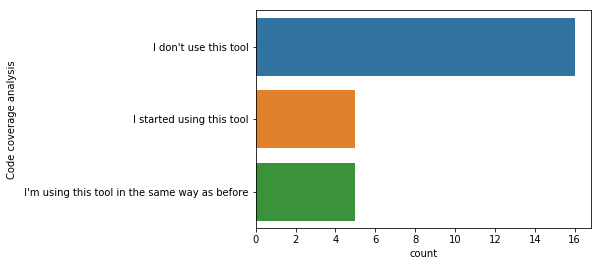

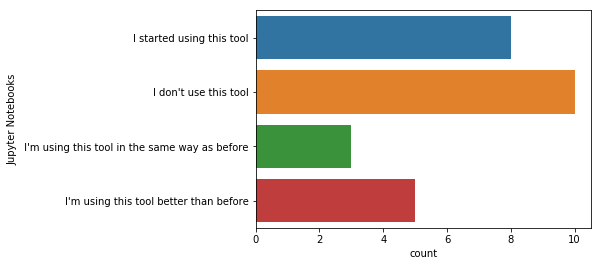

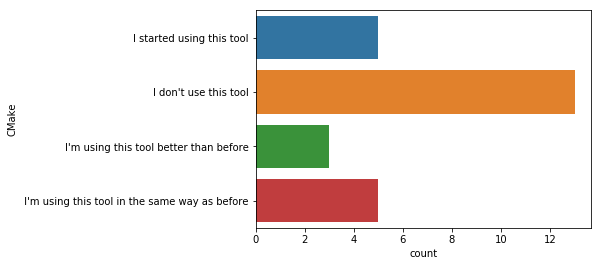

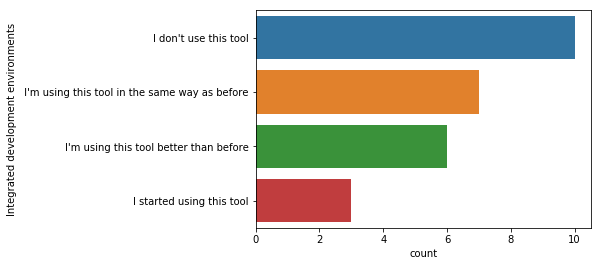

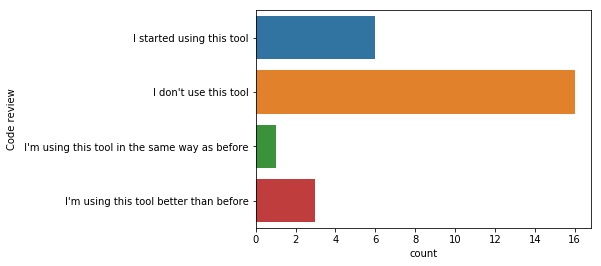

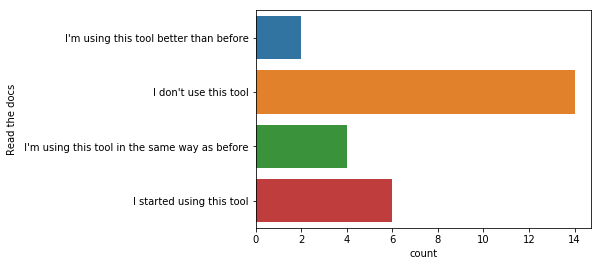

In [13]:
sns.reset_orig()
for i in lessons:
    plt.figure()
    sns.countplot(y=i,data=df)
plt.show()